In [128]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

## Load data

In [167]:
# df = pd.read_csv("data/Pollstar_all_genres.csv")
df = pd.read_csv("data/POP_49824rows_DEC2015_sp_yt_usdemogr.csv")
# df = df.loc[df['Country']=='United States']

/var/folders/7t/162mp27s01zd9vjv97ym_ghh0000gn/T/ipykernel_16936/1156852876.py:2: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/POP_49824rows_DEC2015_sp_yt_usdemogr.csv")


## Data cleaning

In [168]:
df = df.dropna(subset=['sp artist_name', 'yt Title', 'Avg. Capacity Sold', 'Ticket Price Avg. USD'])

In [169]:
df['Avg. Gross USD'] = df['Avg. Gross USD'].apply(lambda x: float(x.replace(',', '').replace('$', '')))
df['Avg. Event Capacity'] = df['Avg. Event Capacity'].apply(lambda x: float(x.replace(',', '')))
df['Avg. Tickets Sold'] = df['Avg. Tickets Sold'].apply(lambda x: float(x.replace(',', '')))
df['Avg. Capacity Sold'] = df['Avg. Capacity Sold'].apply(lambda x: float(x.replace('%', '').replace('null', '0'))/100)
df['Ticket Price Avg. USD'] = df['Ticket Price Avg. USD'].apply(lambda x: float(x.replace(',', '').replace('$', '')) if type(x) is str else x)
df['Ticket Price Min USD'] = df['Ticket Price Min USD'].apply(lambda x: float(x.replace(',', '').replace('$', '')) if type(x) is str else x)
df['Ticket Price Max USD'] = df['Ticket Price Max USD'].apply(lambda x: float(x.replace(',', '').replace('$', '')) if type(x) is str else x)

## Preprocess

In [170]:
df['Ticket Price Max USD'] = np.maximum(df['Ticket Price Max USD'], df['Ticket Price Min USD'])

In [171]:
df['log Avg. Gross USD'] = np.log10(df['Avg. Gross USD'])
df['log Avg. Event Capacity'] = np.log10(df['Avg. Event Capacity'])
df['log Ticket Price Avg. USD'] = np.log10(df['Ticket Price Avg. USD'])
df['log Ticket Price Min USD'] = np.log10(np.maximum(df['Ticket Price Min USD'],1))
df['log Ticket Price Max USD'] = np.log10(np.maximum(df['Ticket Price Max USD'],1))
# df['log yt Subscriber Count'] = np.log10(df['yt Subscriber Count'])
df['log capacity times log avg ticket price'] = np.multiply(df['log Avg. Event Capacity'], df['log Ticket Price Avg. USD'])
df['log capacity times log avg ticket price squared'] = np.power(np.multiply(df['log Avg. Event Capacity'], df['log Ticket Price Avg. USD']), 2)
df['log capacity times log min ticket price'] = np.multiply(df['log Avg. Event Capacity'], df['log Ticket Price Min USD'])
df['log capacity times log min ticket price squared'] = np.power(np.multiply(df['log Avg. Event Capacity'], df['log Ticket Price Min USD']), 2)
df['log capacity times log max ticket price'] = np.multiply(df['log Avg. Event Capacity'], df['log Ticket Price Max USD'])
df['log capacity times log max ticket price squared'] = np.power(np.multiply(df['log Avg. Event Capacity'], df['log Ticket Price Max USD']), 2)
# df['sp popularity squared'] = np.power(df['sp popularity'], 2)

In [172]:
df['Ticket Price Mid USD'] = (df['Ticket Price Min USD'] + df['Ticket Price Max USD'])/2
df['log Ticket Price Mid USD'] = np.log10(np.maximum(df['Ticket Price Mid USD'],1))
df['log capacity times log mid ticket price'] = np.multiply(df['log Avg. Event Capacity'], df['log Ticket Price Mid USD'])
df['log capacity times log mid ticket price squared'] = np.power(np.multiply(df['log Avg. Event Capacity'], df['log Ticket Price Mid USD']), 2)

In [173]:
df['Event Date'] = pd.to_datetime(df['Event Date'], format='%m/%d/%Y')
# df['Event Date'] = pd.to_datetime(df['Event Date'], format='%Y-%m-%d')
df['Month'] = df['Event Date'].dt.month
# df['Month squared'] = np.power(df['Month'], 2)
df['day_of_week'] = df['Event Date'].dt.day_of_week

## EDA

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

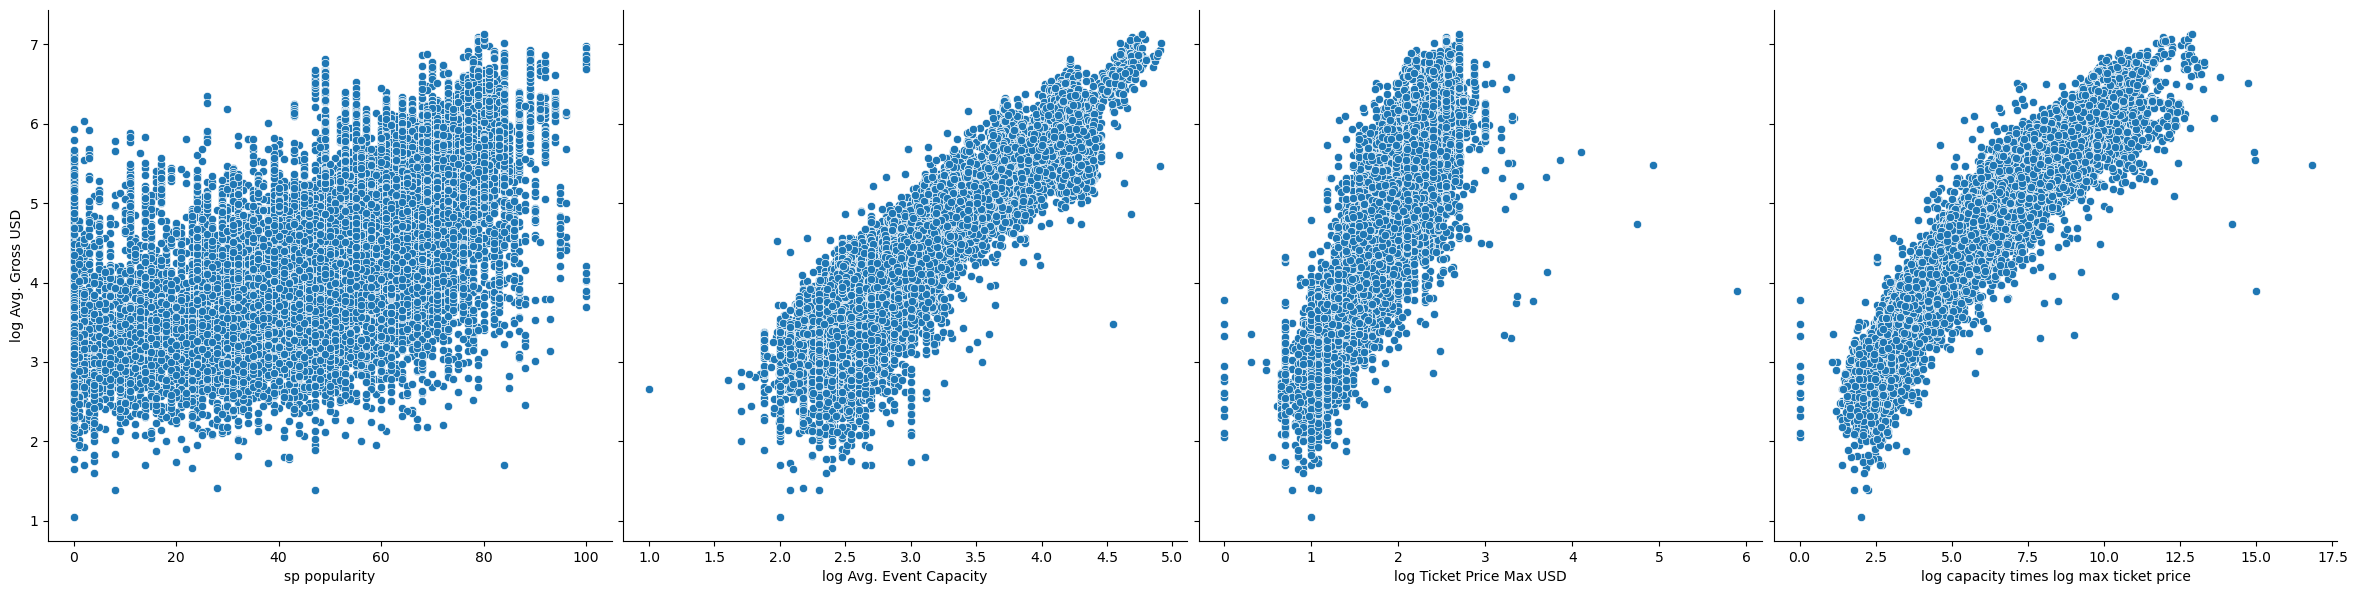

In [143]:
sns.pairplot(data = df,
                x_vars = ['sp popularity', 'log Avg. Event Capacity', 'log Ticket Price Max USD', 'log capacity times log max ticket price'],
                y_vars = ['log Avg. Gross USD'],
                height = 6)
plt.show()

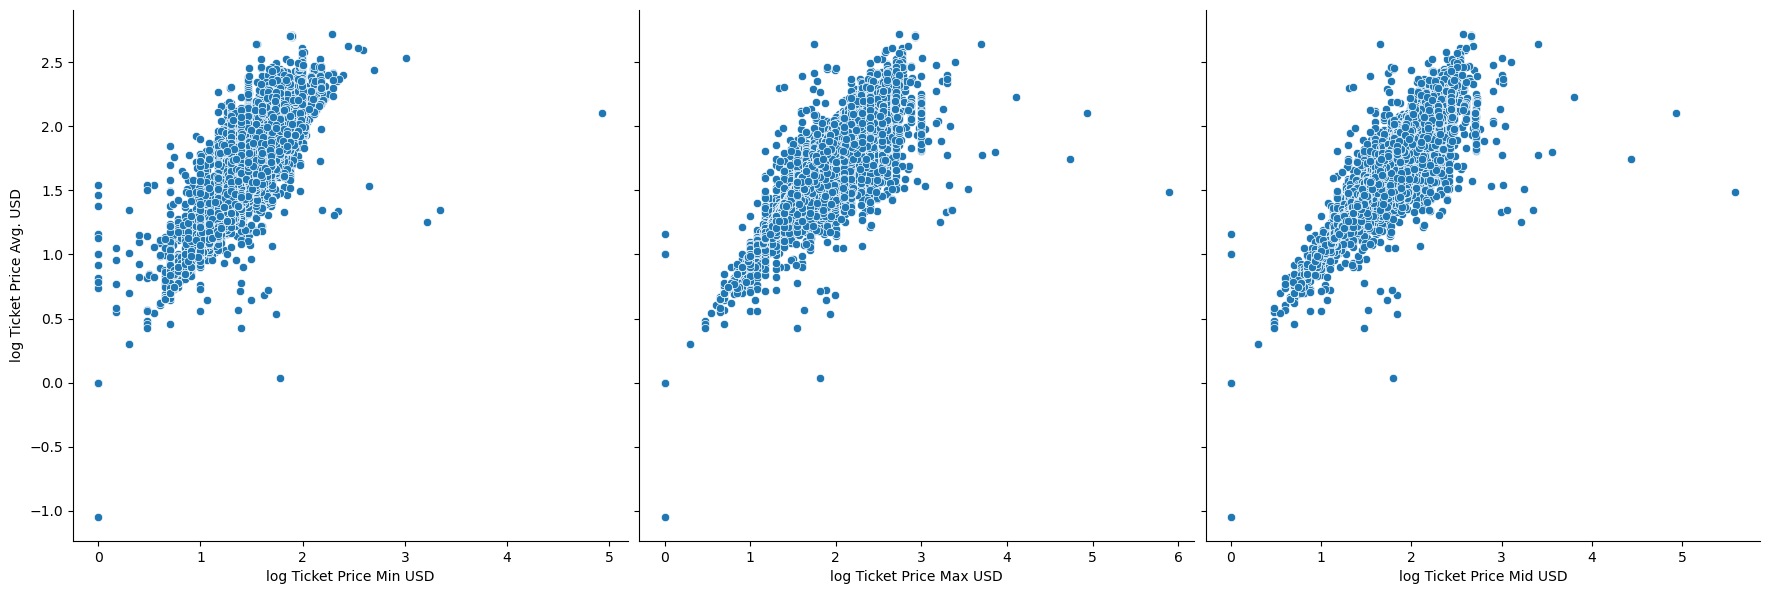

In [144]:
sns.pairplot(data = df,
                x_vars = ['log Ticket Price Min USD', 'log Ticket Price Max USD', 'log Ticket Price Mid USD'],
                y_vars = ['log Ticket Price Avg. USD'],
                height = 6)
plt.show()

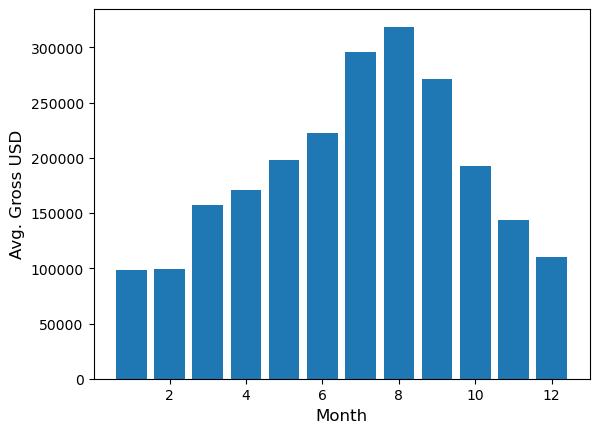

In [145]:
plt.bar(range(1,13), df.groupby('Month')['Avg. Gross USD'].mean())
plt.ylabel("Avg. Gross USD", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.show()

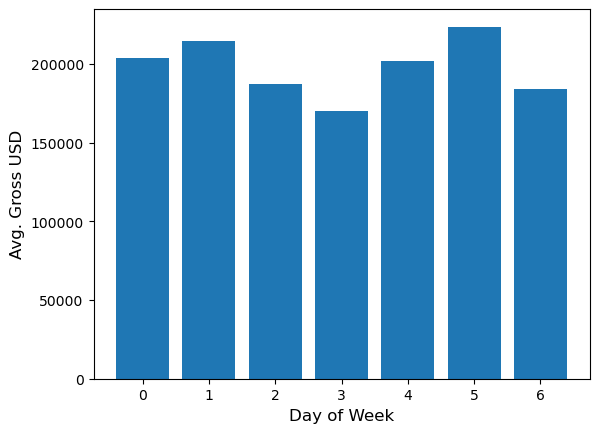

In [146]:
plt.bar(range(0, 7), df.groupby('day_of_week')['Avg. Gross USD'].mean())
plt.ylabel("Avg. Gross USD", fontsize=12)
plt.xlabel("Day of Week", fontsize=12)
plt.show()

In [147]:
states = df['State'].unique()
states = states[~pd.isnull(states)]
states.sort()

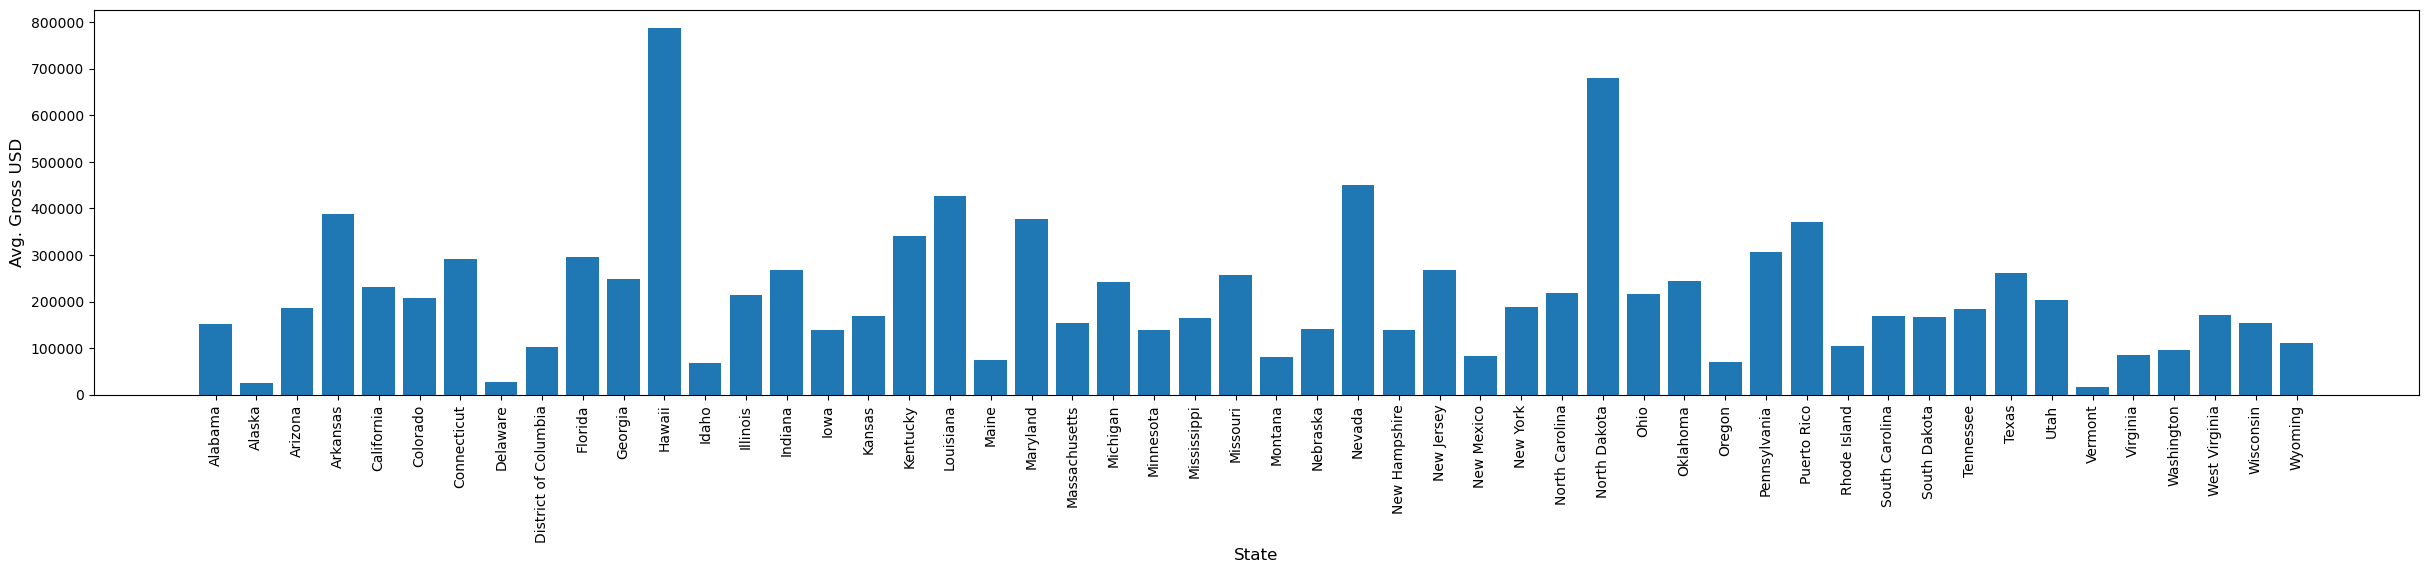

In [148]:
plt.figure(figsize=(30,5))
plt.bar(states, df.groupby('State')['Avg. Gross USD'].mean())
plt.ylabel("Avg. Gross USD", fontsize=12)
plt.xlabel("State", fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Tests

In [199]:
kfold_num = 5
test_num = 10

log

In [ ]:
numerical_features = [
                      'sp popularity',
                      'log Avg. Event Capacity',
                      'log Ticket Price Max USD',
                      'log capacity times log max ticket price',
                      'log capacity times log max ticket price squared',
                    #   'log Ticket Price Min USD',
                    #   'log capacity times log min ticket price',
                    #   'log capacity times log min ticket price squared',
                      # 'log Ticket Price Mid USD',
                      # 'log capacity times log mid ticket price',
                      # 'log capacity times log mid ticket price squared',
                      'Month',
                      'day_of_week',
                      # 'Month squared'
                      'Number of Shows',
                      # 'Median age'
                      ]
categorical_features = []
target = 'log Avg. Gross USD'

In [151]:
alpha = 0.001

random_states = np.random.randint(10000, size=test_num)

lasso_rmses = np.zeros((test_num, kfold_num))
lasso_mses = np.zeros((test_num, kfold_num))
lasso_maes = np.zeros((test_num, kfold_num))
lasso_r2_scores = np.zeros((test_num, kfold_num))

lin_rmses = np.zeros((test_num, kfold_num))
lin_mses = np.zeros((test_num, kfold_num))
lin_maes = np.zeros((test_num, kfold_num))
lin_r2_scores = np.zeros((test_num, kfold_num))

xgb_rmses = np.zeros((test_num, kfold_num))
xgb_mses = np.zeros((test_num, kfold_num))
xgb_maes = np.zeros((test_num, kfold_num))
xgb_r2_scores = np.zeros((test_num, kfold_num))

# ada_rmses = np.zeros((test_num, kfold_num))
# ada_mses = np.zeros((test_num, kfold_num))
# ada_maes = np.zeros((test_num, kfold_num))
# ada_r2_scores = np.zeros((test_num, kfold_num))

knn_rmses = np.zeros((test_num, kfold_num))
knn_mses = np.zeros((test_num, kfold_num))
knn_maes = np.zeros((test_num, kfold_num))
knn_r2_scores = np.zeros((test_num, kfold_num))

gb_rmses = np.zeros((test_num, kfold_num))
gb_mses = np.zeros((test_num, kfold_num))
gb_maes = np.zeros((test_num, kfold_num))
gb_r2_scores = np.zeros((test_num, kfold_num))

for i in range(test_num):
    kfold = KFold(kfold_num, shuffle=True, random_state=random_states[i])
    for j, (train_index, test_index) in enumerate(kfold.split(df)):
        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
            
        scaler = StandardScaler()

        scaled_train_data = np.zeros((len(df_train), len(numerical_features)+len(categorical_features)))

        scaled_train_data[:,:len(numerical_features)] = scaler.fit_transform(df_train[numerical_features])
        scaled_train_data[:,len(numerical_features):len(numerical_features)+len(categorical_features)] = df_train[categorical_features]
        
        lasso = Lasso(alpha = alpha, max_iter = 100000)
        lin = LinearRegression()
        xgb = xgboost.XGBRegressor(max_depth=5, learning_rate=.1)
        # ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators=100, loss='linear', learning_rate=0.5, random_state=123)
        knn = KNeighborsRegressor()
        gb = GradientBoostingRegressor(max_depth=5, learning_rate=.1)


        lasso.fit(scaled_train_data, df_train[target])
        lin.fit(scaled_train_data, df_train[target])
        xgb.fit(scaled_train_data, df_train[target])
        # ada.fit(scaled_train_data, df_train[target])
        knn.fit(scaled_train_data, df_train[target])
        gb.fit(scaled_train_data, df_train[target])

        scaled_test_data = np.zeros((len(df_test), len(numerical_features)+len(categorical_features)))
        scaled_test_data[:,:len(numerical_features)] = scaler.transform(df_test[numerical_features])
        scaled_test_data[:,len(numerical_features):len(numerical_features)+len(categorical_features)] = df_test[categorical_features]

        lasso_pred = np.power(10, lasso.predict(scaled_test_data))
        lin_pred = np.power(10, lin.predict(scaled_test_data))
        xgb_pred = np.power(10, xgb.predict(scaled_test_data))
        # ada_pred = np.power(10, ada.predict(scaled_test_data))
        knn_pred = np.power(10, knn.predict(scaled_test_data))
        gb_pred = np.power(10, gb.predict(scaled_test_data))

        lasso_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], lasso_pred))
        lasso_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], lasso_pred)
        lasso_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], lasso_pred)
        lasso_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], lasso_pred)

        lin_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], lin_pred))
        lin_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], lin_pred)
        lin_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], lin_pred)
        lin_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], lin_pred)

        xgb_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], xgb_pred))
        xgb_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], xgb_pred)
        xgb_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], xgb_pred)
        xgb_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], xgb_pred)

        # ada_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], ada_pred))
        # ada_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], ada_pred)
        # ada_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], ada_pred)
        # ada_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], ada_pred)

        knn_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], knn_pred))
        knn_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], knn_pred)
        knn_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], knn_pred)
        knn_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], knn_pred)

        gb_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], gb_pred))
        gb_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], gb_pred)
        gb_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], gb_pred)
        gb_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], gb_pred)


In [152]:
result_df = pd.DataFrame.from_dict({"Model": ["lasso",
                                              "linear",
                                              "xgboost",
                                            #   "adaboost",
                                              "knn",
                                              "gradient boost"],
                                    "RMSE": [np.mean(lasso_rmses),
                                             np.mean(lin_rmses),
                                             np.mean(xgb_rmses),
                                            #  np.mean(ada_rmses),
                                             np.mean(knn_rmses),
                                             np.mean(gb_rmses)],
                                    "MAE": [np.mean(lasso_maes),
                                            np.mean(lin_maes),
                                            np.mean(xgb_maes),
                                            # np.mean(ada_maes),
                                            np.mean(knn_maes),
                                            np.mean(gb_maes)],
                                    "R2 Score": [np.mean(lasso_r2_scores),
                                                 np.mean(lin_r2_scores),
                                                 np.mean(xgb_r2_scores),
                                                #  np.mean(ada_r2_scores),
                                                 np.mean(knn_r2_scores),
                                                 np.mean(gb_r2_scores)]
                                    })

In [153]:
result_df

,Model,RMSE,MAE,R2 Score
0,lasso,380061.909504,93757.302327,0.612214
1,linear,385186.471748,94232.115124,0.605713
2,xgboost,231794.721737,64459.054936,0.856946
3,knn,258894.556207,72626.501170,0.821699
4,gradient boost,231131.783541,64586.194179,0.857827


no log

In [195]:
numerical_features = [
                      'sp popularity',
                      'sp followers',
                      'Avg. Event Capacity',
                    #   'Ticket Price Min USD',
                      'Ticket Price Max USD',
                      'Month',
                      'day_of_week',
                      'Number of Shows',
                      ]
categorical_features = []
target = 'Avg. Gross USD'

In [196]:
alpha = 0.001

random_states = np.random.randint(10000, size=test_num)

lasso_rmses = np.zeros((test_num, kfold_num))
lasso_mses = np.zeros((test_num, kfold_num))
lasso_maes = np.zeros((test_num, kfold_num))
lasso_r2_scores = np.zeros((test_num, kfold_num))

lin_rmses = np.zeros((test_num, kfold_num))
lin_mses = np.zeros((test_num, kfold_num))
lin_maes = np.zeros((test_num, kfold_num))
lin_r2_scores = np.zeros((test_num, kfold_num))

xgb_rmses = np.zeros((test_num, kfold_num))
xgb_mses = np.zeros((test_num, kfold_num))
xgb_maes = np.zeros((test_num, kfold_num))
xgb_r2_scores = np.zeros((test_num, kfold_num))

# ada_rmses = np.zeros((test_num, kfold_num))
# ada_mses = np.zeros((test_num, kfold_num))
# ada_maes = np.zeros((test_num, kfold_num))
# ada_r2_scores = np.zeros((test_num, kfold_num))

knn_rmses = np.zeros((test_num, kfold_num))
knn_mses = np.zeros((test_num, kfold_num))
knn_maes = np.zeros((test_num, kfold_num))
knn_r2_scores = np.zeros((test_num, kfold_num))

gb_rmses = np.zeros((test_num, kfold_num))
gb_mses = np.zeros((test_num, kfold_num))
gb_maes = np.zeros((test_num, kfold_num))
gb_r2_scores = np.zeros((test_num, kfold_num))

for i in range(test_num):
    kfold = KFold(kfold_num, shuffle=True, random_state=random_states[i])
    for j, (train_index, test_index) in enumerate(kfold.split(df)):
        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
            
        # scaler = StandardScaler()

        # scaled_train_data = np.zeros((len(df_train), len(numerical_features)+len(categorical_features)))

        # scaled_train_data[:,:len(numerical_features)] = scaler.fit_transform(df_train[numerical_features])
        # scaled_train_data[:,len(numerical_features):len(numerical_features)+len(categorical_features)] = df_train[categorical_features]

        train_data = df_train[numerical_features+categorical_features]
        
        lasso = Lasso(alpha = alpha, max_iter = 100000)
        lin = LinearRegression()
        xgb = xgboost.XGBRegressor(max_depth=5, learning_rate=.1)
        # ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators=100, loss='linear', learning_rate=0.5, random_state=123)
        knn = KNeighborsRegressor()
        gb = GradientBoostingRegressor(max_depth=5, learning_rate=.1)



        lasso.fit(train_data, df_train[target])
        lin.fit(train_data, df_train[target])
        xgb.fit(train_data, df_train[target])
        # ada.fit(scaled_train_data, df_train[target])
        knn.fit(train_data, df_train[target])
        gb.fit(train_data, df_train[target])

        # scaled_test_data = np.zeros((len(df_test), len(numerical_features)+len(categorical_features)))
        # scaled_test_data[:,:len(numerical_features)] = scaler.transform(df_test[numerical_features])
        # scaled_test_data[:,len(numerical_features):len(numerical_features)+len(categorical_features)] = df_test[categorical_features]

        test_data = df_test[numerical_features+categorical_features]

        lasso_pred = lasso.predict(test_data)
        lin_pred = lin.predict(test_data)
        xgb_pred = xgb.predict(test_data)
        # ada_pred = np.power(10, ada.predict(scaled_test_data))
        knn_pred = knn.predict(test_data)
        gb_pred = gb.predict(test_data)

        lasso_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], lasso_pred))
        lasso_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], lasso_pred)
        lasso_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], lasso_pred)
        lasso_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], lasso_pred)

        lin_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], lin_pred))
        lin_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], lin_pred)
        lin_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], lin_pred)
        lin_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], lin_pred)

        xgb_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], xgb_pred))
        xgb_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], xgb_pred)
        xgb_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], xgb_pred)
        xgb_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], xgb_pred)

        # ada_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], ada_pred))
        # ada_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], ada_pred)
        # ada_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], ada_pred)
        # ada_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], ada_pred)

        knn_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], knn_pred))
        knn_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], knn_pred)
        knn_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], knn_pred)
        knn_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], knn_pred)

        gb_rmses[i][j] = np.sqrt(mean_squared_error(df_test['Avg. Gross USD'], gb_pred))
        gb_mses[i][j] = mean_squared_error(df_test['Avg. Gross USD'], gb_pred)
        gb_maes[i][j] = mean_absolute_error(df_test['Avg. Gross USD'], gb_pred)
        gb_r2_scores[i][j] = r2_score(df_test['Avg. Gross USD'], gb_pred)


In [197]:
result_df = pd.DataFrame.from_dict({"Model": ["lasso",
                                              "linear",
                                              "xgboost",
                                            #   "adaboost",
                                              "knn",
                                              "gradient boost"],
                                    "RMSE": [np.mean(lasso_rmses),
                                             np.mean(lin_rmses),
                                             np.mean(xgb_rmses),
                                            #  np.mean(ada_rmses),
                                             np.mean(knn_rmses),
                                             np.mean(gb_rmses)],
                                    "MAE": [np.mean(lasso_maes),
                                            np.mean(lin_maes),
                                            np.mean(xgb_maes),
                                            # np.mean(ada_maes),
                                            np.mean(knn_maes),
                                            np.mean(gb_maes)],
                                    "R2 Score": [np.mean(lasso_r2_scores),
                                                 np.mean(lin_r2_scores),
                                                 np.mean(xgb_r2_scores),
                                                #  np.mean(ada_r2_scores),
                                                 np.mean(knn_r2_scores),
                                                 np.mean(gb_r2_scores)]
                                    })

In [198]:
result_df

,Model,RMSE,MAE,R2 Score
0,lasso,363620.333742,133403.687290,0.651965
1,linear,363620.333605,133403.687641,0.651965
2,xgboost,175188.049989,54978.321060,0.918632
3,knn,210931.061104,59109.279262,0.882989
4,gradient boost,172032.005028,53304.985403,0.921048
